<a href="https://colab.research.google.com/github/giakomorssi/Deloitte_Project/blob/main/Deloitte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prima parte

## Import Data

In [69]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Change Colab runtime to GPU
import os
os.environ['COLAB_TPU_ADDR'] = ''
os.environ['COLAB_GPU_ALLOC'] = '1'
os.environ['COLAB_GPU'] = '1'
print("Runtime switched to GPU")

import tensorflow as tf

if not tf.test.gpu_device_name():
    print('GPU device not found')
else:
    print('GPU device found:', tf.test.gpu_device_name())

# This code sets the runtime to use the GPU if available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


pd.set_option('display.max_columns', None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Runtime switched to GPU
GPU device found: /device:GPU:0
Default GPU Device: /device:GPU:0


In [70]:
df = pd.read_csv('/content/drive/MyDrive/University/Deloitte/SupplyChainDataset.csv', encoding = 'latin-1')

## Cleaning

### Remove Na and Empty Columns

In [71]:
df.isna().sum()

Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0


In [72]:
df.drop(['Product Description', 'Order Zipcode', 'Customer Email', 'Customer Password'], axis = 1, inplace = True) #empty columns 
df.dropna(inplace = True) #remove 1 missing value

In [73]:
df.isna().sum()

Type                             0
Days for shipping (real)         0
Days for shipment (scheduled)    0
Benefit per order                0
Sales per customer               0
Delivery Status                  0
Late_delivery_risk               0
Category Id                      0
Category Name                    0
Customer City                    0
Customer Country                 0
Customer Fname                   0
Customer Id                      0
Customer Lname                   0
Customer Segment                 0
Customer State                   0
Customer Street                  0
Customer Zipcode                 0
Department Id                    0
Department Name                  0
Latitude                         0
Longitude                        0
Market                           0
Order City                       0
Order Country                    0
Order Customer Id                0
order date (DateOrders)          0
Order Id                         0
Order Item Cardprod 

## Encoding

### Type

In [74]:
# One-hot encode the TYPE variable
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Type_Encoded'] = le.fit_transform(df['Type'])

col_c = df.pop('Type_Encoded')
posizione = df.columns.get_loc("Type")
df.insert(posizione+1, 'Type_Encoded', col_c)

print(posizione, '\n')

print("Original labels:", le.classes_, '\n')

0 

Original labels: ['CASH' 'DEBIT' 'PAYMENT' 'TRANSFER'] 



### Delivery Status

In [75]:
le = LabelEncoder()
df['Delivery Status_Encoded'] = le.fit_transform(df['Delivery Status'])

col_c = df.pop('Delivery Status_Encoded')
posizione = df.columns.get_loc("Delivery Status")
df.insert(posizione+1, 'Delivery Status_Encoded', col_c)

print(posizione, '\n')

print("Original labels:", le.classes_, '\n')

6 

Original labels: ['Advance shipping' 'Late delivery' 'Shipping canceled' 'Shipping on time'] 



### Customer Segment

In [76]:
le = LabelEncoder()
df['Customer Segment_Encoded'] = le.fit_transform(df['Customer Segment'])

col_c = df.pop('Customer Segment_Encoded')
posizione = df.columns.get_loc("Customer Segment")
df.insert(posizione+1, 'Customer Segment_Encoded', col_c)

print(posizione, '\n')

print("Original labels:", le.classes_, '\n')

16 

Original labels: ['Consumer' 'Corporate' 'Home Office'] 



### Order Status

In [77]:
le = LabelEncoder()
df['Order Status_Encoded'] = le.fit_transform(df['Order Status'])

col_c = df.pop('Order Status_Encoded')
posizione = df.columns.get_loc("Order Status")
df.insert(posizione+1, 'Order Status_Encoded', col_c)

print(posizione, '\n')

print("Original labels:", le.classes_, '\n')

43 

Original labels: ['CANCELED' 'CLOSED' 'COMPLETE' 'ON_HOLD' 'PAYMENT_REVIEW' 'PENDING'
 'PENDING_PAYMENT' 'PROCESSING' 'SUSPECTED_FRAUD'] 



### Shipping Mode

In [78]:
le = LabelEncoder()
df['Shipping Mode_Encoded'] = le.fit_transform(df['Shipping Mode'])

col_c = df.pop('Shipping Mode_Encoded')
posizione = df.columns.get_loc("Shipping Mode")
df.insert(posizione+1, 'Shipping Mode_Encoded', col_c)

print(posizione, '\n')

print("Original labels:", le.classes_, '\n')

52 

Original labels: ['First Class' 'Same Day' 'Second Class' 'Standard Class'] 



## Check Columns

### Benefit Per Order and Order Profit Per Order

In [79]:
# these two columns are the same
(df['Order Profit Per Order'] == df['Benefit per order']).sum()

#remove one
df.drop(['Order Profit Per Order'], inplace = True, axis = 1)

In [80]:
len([x for x in df['Benefit per order'] if x < 0])
# decide what to do with negatives

33782

# Fraud Detection

## Order Status



1. **COMPLETE:** The order or transaction has been successfully fulfilled and completed.
2. **PENDING**: The order or transaction is still in progress and has not yet been completed.
3. **CLOSED**: The order or transaction has been closed or terminated for some reason, such as a return or cancellation.
4. **PENDING_PAYMENT**: The order or transaction is awaiting payment before it can be processed.
5. **CANCELED**: The order or transaction has been canceled by the customer or the seller for some reason.
6. **PROCESSING**: The order or transaction is being processed by the seller or merchant.
7. **SUSPECTED_FRAUD**: The order or transaction is under review due to suspected fraudulent activity.
8. **ON_HOLD**: The order or transaction has been placed on hold for some reason, such as a delay in shipping or a credit hold.
9. **PAYMENT_REVIEW**: The payment for the order or transaction is under review by the payment processor or financial institution.

In [81]:
# Regular -> Complete, Pending, Pending_Payment, Processing
# Suspected -> Closed, Canceled, On_Hold, Payment_Review
# Fraud -> Suspected_Fraud

# define dictionaries to map status values to categories
regular_dict = {'COMPLETE': 'Regular', 'PENDING': 'Regular', 'PENDING_PAYMENT': 'Regular', 'PROCESSING': 'Regular'}
suspected_dict = {'CLOSED': 'Suspected', 'CANCELED': 'Suspected', 'ON_HOLD': 'Suspected', 'PAYMENT_REVIEW': 'Suspected'}
fraud_dict = {'SUSPECTED_FRAUD': 'Fraud'}

# create a function to map status values to categories
def map_category(status):
    if status in regular_dict:
        return regular_dict[status]
    elif status in suspected_dict:
        return suspected_dict[status]
    elif status in fraud_dict:
        return fraud_dict[status]
    else:
        return 'Unknown'

# apply the function to the 'status' column to create a new 'category' column
df['Category'] = df['Order Status'].apply(map_category)

In [82]:
le = LabelEncoder()
df['Category_Encoded'] = le.fit_transform(df['Category'])

col_c = df.pop('Category_Encoded')
posizione = df.columns.get_loc("Category")
df.insert(posizione+1, 'Category_Encoded', col_c)

print(posizione, '\n')

print("Original labels:", le.classes_, '\n')
print("labels:", '\n',df['Category_Encoded'], '\n')

53 

Original labels: ['Fraud' 'Regular' 'Suspected'] 

labels: 
 0         1
1         1
2         2
3         1
4         1
         ..
180514    2
180515    1
180516    1
180517    1
180518    1
Name: Category_Encoded, Length: 180508, dtype: int64 



In [83]:
print('Regular: ', len([x for x in df['Category'] if x == 'Regular']), '\n')
print('Suspected: ', len([x for x in df['Category'] if x == 'Suspected']), '\n')
print('Fraud: ', len([x for x in df['Category'] if x == 'Fraud']))

Regular:  141442 

Suspected:  35004 

Fraud:  4062


## Data preprocessing


In [84]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

s = StandardScaler()

df_nn = df.drop(['Type', 'Delivery Status', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Fname', 'Customer Id', 'Customer Lname',
       'Customer Segment', 'Customer State',	'Customer Street', 'Department Name', 
       'Market', 'Order City', 'Order Country', 'Order Customer Id', 'Order Region',	
       'Order State', 'Order Status', 'Product Image',	'Product Name', 'Shipping Mode', 'Category',
       'shipping date (DateOrders)', 'order date (DateOrders)', 'Category Id', 'Customer Zipcode', 
       'Department Id', 'Latitude',	'Longitude', 'Order Id',	'Order Item Cardprod Id',
       'Order Item Id', 'Product Card Id', 'Product Category Id'], axis = 1)

X = df_nn.drop('Category_Encoded', axis = 1)
y = df_nn['Category_Encoded']

X = s.fit_transform(X)

## PCA

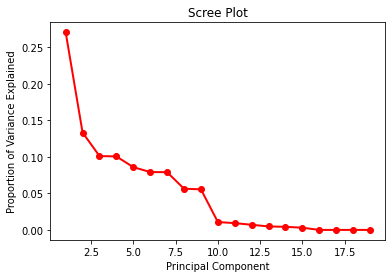

Number of components to keep: 9


In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize a PCA object
pca = PCA()

# Fit the PCA object to the data
pca.fit(X)

# Create a scree plot
num_components = len(pca.explained_variance_ratio_)
plt.plot(np.arange(1, num_components+1), pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

# Determine the number of components to keep
variance_threshold = 0.95
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
num_components_to_keep = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1

print(f'Number of components to keep: {num_components_to_keep}')

# Transform the data using the chosen number of components
pca = PCA(n_components=num_components_to_keep)
X_pca = pca.fit_transform(X)

## Split the data into training and test sets

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=4, stratify=y)

In [87]:
w_f = y_train.value_counts()[0] / len(y_train)
w_r = y_train.value_counts()[1] / len(y_train)
w_s = y_train.value_counts()[2] / len(y_train)


print(f"Fraudulant transaction weight: {w_f}")
print(f"Non-Fraudulant transaction weight: {w_r}")
print(f"Suspected transaction weight: {w_s}")

Fraudulant transaction weight: 0.022505990055814856
Non-Fraudulant transaction weight: 0.7835754747032672
Suspected transaction weight: 0.19391853524091796


In [88]:
print(f"TRAINING: X_train: {X_train.shape}, y_train: {y_train.shape}\n")
print(f"TESTING: X_test: {X_test.shape}, y_test: {y_test.shape}")

TRAINING: X_train: (144406, 9), y_train: (144406,)

TESTING: X_test: (36102, 9), y_test: (36102,)


## Random Forest

### Model



```
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=10) # initialize the model with 10 trees
rf_model.fit(X_train, y_train) # train the model on the training data

# save the model

with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
```



### Load the model and make predictions on the testing set

In [89]:
import pickle

# Load the saved XGBoost model from file
with open('/content/drive/MyDrive/University/Deloitte/rf_model.pkl', 'rb') as f:
    rf_model = pickle.load(f)

# Use the loaded model to make predictions on the test data
y_pred = rf_model.predict(X_test) # make predictions on the testing data


In [90]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

print("Accuracy score: ", accuracy_score(y_test, y_pred), '\n')
print('recall score:', recall_score(y_test, y_pred, average="macro"), '\n')
print('precision score:', precision_score(y_test, y_pred, average="macro"), '\n')
print('f1 score:', f1_score(y_test, y_pred, average="macro"), '\n')
print("Confusion matrix: ", '\n', confusion_matrix(y_test, y_pred), '\n')

Accuracy score:  0.9965375879452661 

recall score: 0.9930314371159762 

precision score: 0.9980234251318946 

f1 score: 0.9955020004754372 

Confusion matrix:  
 [[  809     2     1]
 [    0 28287     2]
 [    1   119  6881]] 



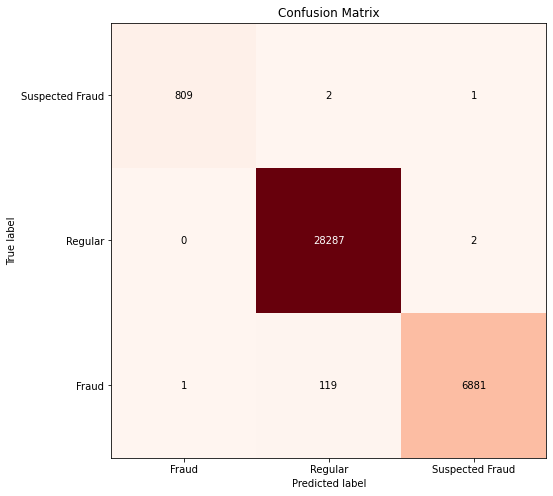

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix 

class_names = ['Fraud', 'Regular', 'Suspected Fraud']
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)

# Add labels and title with reversed label order
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=reversed(class_names),
       title='Confusion Matrix',
       xlabel='Predicted label',
       ylabel='True label')

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.show()

## Grid Search XGBoost Model

### Model


```
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import pickle

# Define the parameter grid to search over
param_grid = {
    'max_depth': [5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100]
}

# Create an XGBoost classifier object
xgb = XGBClassifier(objective='multi:softmax', num_class=3)

# Perform a grid search over the parameter grid using cross-validation
grid_search = GridSearchCV(xgb, param_grid=param_grid, cv=3, verbose=3)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters: ", grid_search.best_params_)

# Use the best hyperparameters to train the model and make predictions on the testing set

best_xgb = XGBClassifier(objective='multi:softmax', num_class=3, **grid_search.best_params_)
best_xgb.fit(X_train, y_train)

# save the model

with open('best_xgb.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)
```



### Load the model and make predictions on the test set

In [92]:
import pickle

# Load the saved XGBoost model from file
with open('/content/drive/MyDrive/University/Deloitte/best_xgb.pkl', 'rb') as f:
    best_xgb = pickle.load(f)

# Use the loaded model to make predictions on the test data
y_pred = best_xgb.predict(X_test)

In [93]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

print("Accuracy score: ", accuracy_score(y_test, y_pred), '\n')
print('recall score:', recall_score(y_test, y_pred, average="macro"), '\n')
print('precision score:', precision_score(y_test, y_pred, average="macro"), '\n')
print('f1 score:', f1_score(y_test, y_pred, average="macro"), '\n')
print("Confusion matrix: ", '\n', confusion_matrix(y_test, y_pred), '\n')

Accuracy score:  0.9966483851310177 

recall score: 0.9936206119876179 

precision score: 0.9984333603431635 

f1 score: 0.9960036482509841 

Confusion matrix:  
 [[  810     1     1]
 [    0 28286     3]
 [    0   116  6885]] 



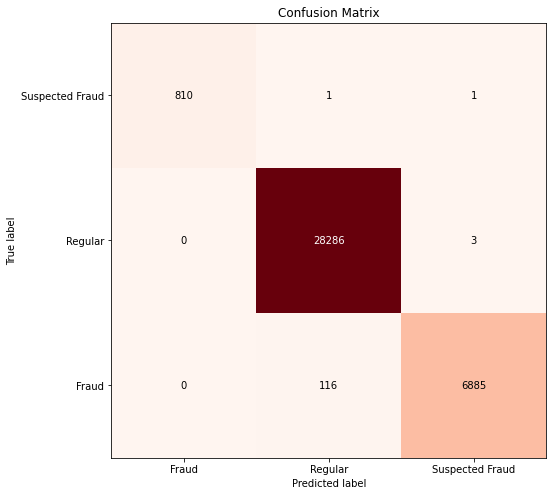

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix 

class_names = ['Fraud', 'Regular', 'Suspected Fraud']
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)

# Add labels and title with reversed label order
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=reversed(class_names),
       title='Confusion Matrix',
       xlabel='Predicted label',
       ylabel='True label')

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.show()

## Comparing Models

```python
# Random Forest 10 trees

Accuracy score:  0.9965375879452661 

recall score: 0.9930314371159762 

precision score: 0.9980234251318946 

f1 score: 0.9955020004754372 
```
---
```python
# XGBoost

Accuracy score:  0.9966483851310177 

recall score: 0.9936206119876179 

precision score: 0.9984333603431635 

f1 score: 0.9960036482509841
```

